In [0]:
!pip install watermark

In [1]:
from platform import python_version
print('version de python usada en este notebook ', python_version())

version de python usada en este notebook  3.6.9


In [0]:
import numpy as np
import tensorflow as tf
import math
from sklearn.metrics import confusion_matrix
import sklearn
import matplotlib.pyplot as plt
import time
from datetime import timedelta
import matplotlib
%matplotlib inline

In [48]:
%reload_ext watermark
%watermark -a "Christian Dayan Arcos Gordillo" --iversion

numpy      1.18.3
tensorflow 2.2.0-rc4
sklearn    0.22.2.post1
matplotlib 3.2.1
Christian Dayan Arcos Gordillo


In [4]:
from google.colab import files
files.upload()

{}

In [0]:
import tensorflow.python.util.deprecation as deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
tf.compat.v1.disable_eager_execution()

In [0]:
#Importando el dataser MNIST con keras
https://www.tensorflow.org/tutorials/quickstart/advanced
(X_train,y_train),(X_test,y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
train_ds = tf.data.Dataset.from_tensor_slices(
    (X_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [6]:
#import mnist con input_data
import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)


Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [7]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [0]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [9]:
data.test.labels[0:5,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [10]:
data.test.cls

array([7, 2, 1, ..., 4, 5, 6])

In [0]:
#configuracion red neuronal

image_size = 28
filters1 = 16
filters1_size = 5
filters2 = 36
filters2_size = 5
neurones_finales = 128

#dimensiones de los datos

flaten_size = image_size*image_size
image_shape = (image_size,image_size)
num_chanels = 1
num_class= 10


In [0]:
def plots(img, labels_true, labels_pred=None):
  assert len(img) == len(labels_true) == 9

  fig, axes = plt.subplots(3,3)
  fig.subplots_adjust(hspace=0.3,wspace=0.3)

  for i, ax in enumerate(axes.flat):
    ax.imshow(img[i].reshape(image_shape),cmap='binary')

    if labels_pred is None:
      xlabel = 'True: {0}'.format(labels_true[i])
    else:
      xlabel = "True: {0} pred: {1}". format(labels_true[i],labels_pred[i])

    ax.set_xlabel(xlabel)

    ax.set_xticks([])
    ax.set_yticks([])

  plt.show()

9
9


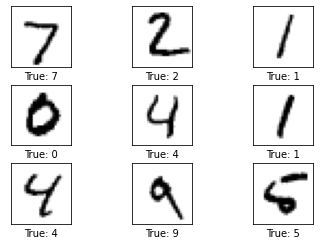

In [14]:
images = data.test.images[0:9]
labels_true = data.test.cls[0:9]
print(len(images))
print(len(labels_true))
plots(images,labels_true)

In [0]:
#Creando nuevas variables para inicialización de pesos y bias 
def new_pesos(shape):
  return tf.Variable(tf.random.truncated_normal(shape, stddev=0.05))

def new_bias(length):
  return tf.Variable(tf.constant(0.05, shape=[length]))

In [0]:
#Camadas de convolución
def conv(input,
         num_chanels,
         filter_size,
         num_filters,
         use_pooling = True):
         
  #shape de filtros para convolución
  shape = [filter_size, filter_size, num_chanels, num_filters]
                 
  #crear nuevos pesos
  weights = new_pesos(shape)      

  bias =new_bias(length=num_filters)

  #el stride [1,1,1,1] significa que el filtro se movera na posicion en x y una en y el primer 1 se refiere a una imagen y el ultimo 1 a un canal
  layer = tf.nn.conv2d(input=input,filters=weights,strides=[1,1,1,1],padding='SAME',)
  #adicionamos a la capa su respectivo bias
  layer +=bias

  #usando pooling para reducir el tamaño de la imagen
  if use_pooling:
    #en este caso usaremos un polling de 2 para reducir la imagen a la mitad y se movera dos pixeles para la proxima ventana
    layer = tf.nn.max_pool2d(input=layer,ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

  #adicionamos la no linealidad con la funcion relu que calculara el max(x,0) para cada pixel de entrada x

  layer = tf.nn.relu(layer)

  #retornamos las camadas y los pesos para visualizacion
  return layer, weights
         

In [0]:
# capa de flatten
def flaten (layer):
  layer_shape = layer.get_shape()

  num_features = layer_shape[1:4].num_elements()

  layer_flat = tf.reshape(layer, [-1, num_features])

  return layer_flat,num_features

In [0]:
# capa totalmente conectaad

def conected(inputs, num_inputs, num_outputs,use_relu=True):

    weights = new_pesos(shape=[num_inputs, num_outputs])
    biases = new_bias(length=num_outputs)

    layer = tf.matmul(inputs, weights) + biases

    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [0]:
x = tf.compat.v1.placeholder(tf.float32, shape=[None, flaten_size], name='x')
x_image = tf.reshape(x, [-1, image_size, image_size, num_chanels])

In [0]:
y_true = tf.compat.v1.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, axis=1)

In [0]:
#Capas convolucionales
layer_conv1, weights_conv1 = conv(input= x_image,num_chanels=num_chanels,filter_size=filters1_size,num_filters=filters1,use_pooling=True)

In [22]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(None, 14, 14, 16) dtype=float32>

In [0]:
layer_conv2, weights_conv2 = conv(input = layer_conv1, num_chanels = filters1, filter_size = filters2_size, num_filters = filters2, use_pooling = True)

In [24]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(None, 7, 7, 36) dtype=float32>

In [0]:
#Capas flatten 
layer_flatten, num_features = flaten(layer_conv2)

In [26]:
layer_flatten

<tf.Tensor 'Reshape_1:0' shape=(None, 1764) dtype=float32>

In [27]:
num_features

1764

In [0]:
#Capas totalmente conectaas

layer_conected1 = conected(layer_flatten, num_features, neurones_finales, use_relu=True)

In [31]:
layer_conected1

<tf.Tensor 'Relu_2:0' shape=(None, 128) dtype=float32>

In [0]:
layer_conected2 = conected(layer_conected1,neurones_finales,num_class,use_relu=False)

In [33]:
layer_conected2

<tf.Tensor 'add_3:0' shape=(None, 10) dtype=float32>

In [0]:
#la ultima capa por serla de las predicciones lleva una funsion softmax
y_pred = tf.nn.softmax(layer_conected2)
y_pred_cls= tf.argmax(y_pred, axis=1)

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_conected2,labels=y_true)

In [0]:
cost = tf.reduce_mean(cross_entropy)

In [0]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [0]:
accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))

In [0]:
#Iniciando sesion
session = tf.compat.v1.Session()

In [0]:
session.run(tf.compat.v1.global_variables_initializer())

In [0]:
train_batch_size = 64

In [0]:
total_iterations = 0

def optimize(num_iterations):
    
    global total_iterations

    # Start-time.
    start_time = time.time()

    for i in range(total_iterations, total_iterations + num_iterations):

        
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)

        
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        
        session.run(optimizer, feed_dict = feed_dict_train)

        # Print
        if i % 100 == 0:
            # Calcula la acurácia
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            
            msg = "Iteración de optimización: {0:>6}, Acurácia en entrenamiento: {1:>6.1%}"

            # Print
            print(msg.format(i + 1, acc))

    
    total_iterations += num_iterations

    
    end_time = time.time()

    
    time_dif = end_time - start_time

    # Print
    print("Tiempor gastado: " + str(timedelta(seconds=int(round(time_dif)))))

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors = False, show_confusion_matrix = False):

    num_test = len(data.test.images)

    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = data.test.images[i:j, :]

        labels = data.test.labels[i:j, :]

        feed_dict = {x: images, y_true: labels}

        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        i = j

    cls_true = data.test.cls

    correct = (cls_true == cls_pred)

    correct_sum = correct.sum()

    acc = float(correct_sum) / num_test

    # Print
    msg = "Acurácia en Teste: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot
    if show_example_errors:
        print("Errores:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)

    images = data.test.images[incorrect]

    cls_pred = cls_pred[incorrect]

    cls_true = data.test.cls[incorrect]

    # Plot
    plots(images[0:9], cls_true[0:9],cls_pred[0:9])

In [0]:
def plot_confusion_matrix(cls_pred):
    cls_true = data.test.cls

    cm = confusion_matrix(y_true = cls_true, y_pred = cls_pred)

    # Print
    print(cm)

    # Plot
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_class)
    plt.xticks(tick_marks, range(num_class))
    plt.yticks(tick_marks, range(num_class))
    plt.xlabel('Predicho')
    plt.ylabel('Label Original')

    plt.show()

In [54]:
#precisión sin entrenamiento
print_test_accuracy()

Acurácia en Teste: 10.3% (1035 / 10000)


In [59]:
optimize(num_iterations=1)

Iteración de optimización:      1, Acurácia en entrenamiento:  32.8%
Tiempor gastado: 0:00:00


In [60]:
#precisión despues de una iteración de  entrenamiento
print_test_accuracy()

Acurácia en Teste: 29.5% (2948 / 10000)


In [61]:
#entrenamiento con 100 iteraciones
optimize(num_iterations=100)

Iteración de optimización:    101, Acurácia en entrenamiento:  89.1%
Tiempor gastado: 0:00:07


Acurácia en Teste: 91.7% (9166 / 10000)
Errores:


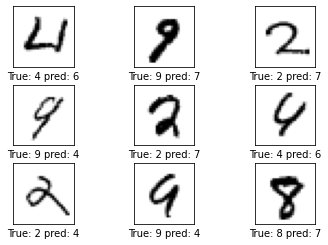

In [68]:
print_test_accuracy(show_example_errors=True)

In [69]:
#entrenamiento con 1000 iteraciones
optimize(num_iterations=1000)

Iteración de optimización:    201, Acurácia en entrenamiento:  98.4%
Iteración de optimización:    301, Acurácia en entrenamiento:  95.3%
Iteración de optimización:    401, Acurácia en entrenamiento: 100.0%
Iteración de optimización:    501, Acurácia en entrenamiento:  93.8%
Iteración de optimización:    601, Acurácia en entrenamiento:  98.4%
Iteración de optimización:    701, Acurácia en entrenamiento:  98.4%
Iteración de optimización:    801, Acurácia en entrenamiento:  98.4%
Iteración de optimización:    901, Acurácia en entrenamiento: 100.0%
Iteración de optimización:   1001, Acurácia en entrenamiento: 100.0%
Iteración de optimización:   1101, Acurácia en entrenamiento: 100.0%
Tiempor gastado: 0:01:08


Acurácia en Teste: 98.6% (9856 / 10000)
Errores:


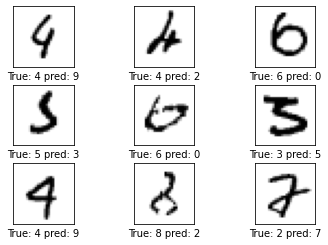

In [70]:
print_test_accuracy(show_example_errors=True)

Acurácia en Teste: 98.6% (9856 / 10000)
Errores:


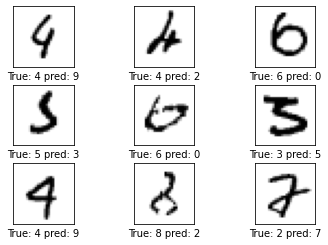

Confusion Matrix:
[[ 973    0    1    0    0    0    3    0    2    1]
 [   0 1116    2    5    1    0    2    1    8    0]
 [   3    0 1022    1    0    0    0    3    3    0]
 [   1    0    0 1004    0    2    0    1    1    1]
 [   0    0    3    0  960    0    1    1    1   16]
 [   2    0    0    5    0  880    2    1    0    2]
 [   7    1    0    1    2    5  942    0    0    0]
 [   0    1    9    3    0    0    0 1008    1    6]
 [   3    0    2    2    0    3    1    3  956    4]
 [   1    2    0    2    2    3    0    3    1  995]]


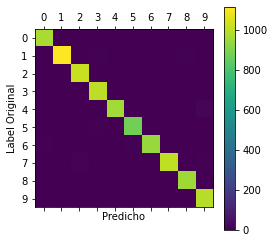

In [73]:
print_test_accuracy(show_example_errors = True, show_confusion_matrix = True)

In [0]:
#Función para graficar los pesos de las capas convolucionales
def plot_conv_weights(weights, input_channel=0):
    w = session.run(weights)

    w_min = np.min(w)
    w_max = np.max(w)

    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))

    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot
    for i, ax in enumerate(axes.flat):
        if i < num_filters:

            img = w[:, :, input_channel, i]

            # Plot
            ax.imshow(img, vmin = w_min, vmax = w_max, interpolation = 'nearest', cmap = 'seismic')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [0]:
#funcion para graficar las salidas de las capas convolucionales
def plot_conv_layer(layer, image):

    feed_dict = {x: [image]}

    values = session.run(layer, feed_dict=feed_dict)

    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))

    fig, axes = plt.subplots(num_grids, num_grids)

    # Plot
    for i, ax in enumerate(axes.flat):
        if i < num_filters:
            img = values[0, :, :, i]

            # Plot
            ax.imshow(img, interpolation = 'nearest', cmap = 'binary')

        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

In [0]:
def plot_image(image):
    plt.imshow(image.reshape(image_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

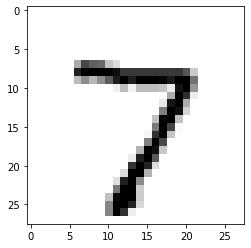

In [80]:
image1 = data.test.images[0]
plot_image(image1)

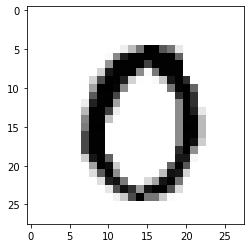

In [81]:
image2 = data.test.images[13]
plot_image(image2)

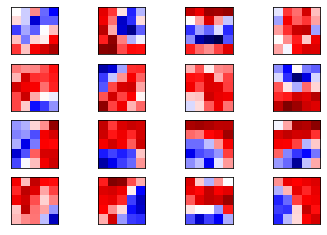

In [82]:
#salidas convolucionales
plot_conv_weights(weights=weights_conv1)

La imágenanterior muestra los pesos de los filtros para la primera capa convolucional en total 16 filtros, se puede ver que los pesos positivos  son rojos y los nevativos son azules, la aplicación de cada uno de esos filtros en la primera imagen de entrada genera los siguientes  imagenes de salida que seran utilizadas como entrada para la segunda capa convolucional, note qu elas imagenes son reducidas a 14 x 14 pixeles 

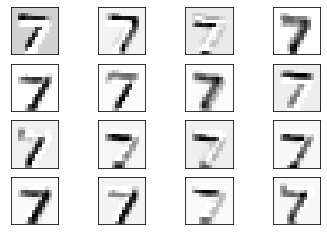

In [83]:
plot_conv_layer(layer = layer_conv1, image = image1)

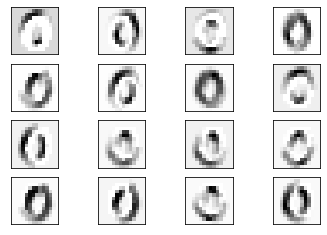

In [84]:
plot_conv_layer(layer=layer_conv1, image=image2)

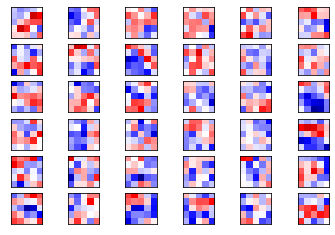

In [85]:
#salida de los filtros de convolcuion de la capa 2
plot_conv_weights(weights = weights_conv2, input_channel = 0)

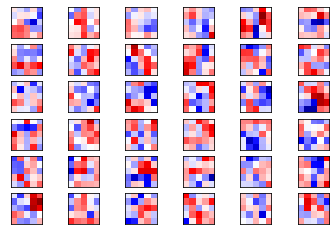

In [86]:
plot_conv_weights(weights = weights_conv2, input_channel = 1)

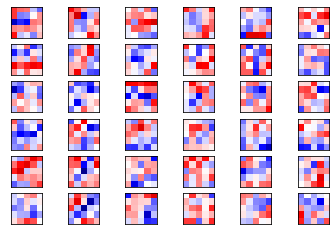

In [89]:
plot_conv_weights(weights = weights_conv2, input_channel = 5)

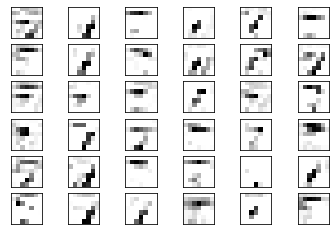

In [87]:
plot_conv_layer(layer=layer_conv2, image=image1)

Los anteriores son los resultados de aplicar los filtros en la segunda capa de convolucion para la primera imagen

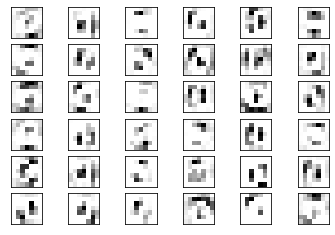

In [88]:
plot_conv_layer(layer=layer_conv2, image=image2)

In [0]:
session.close()